In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr30k")

print("Path to dataset files:", path)

100%|██████████| 8.16G/8.16G [01:20<00:00, 109MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1


In [ ]:
import os, pickle, torch, torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import random
from collections import Counter


def find_image_dir(base_path):
    # Check for common image directory names
    possible_dirs = ['Images', 'images', 'flickr30k_images', 'flickr30k/images']

    # First check direct subdirectories
    for dir_name in possible_dirs:
        img_path = os.path.join(base_path, dir_name)
        if os.path.exists(img_path):
            jpg_files = [f for f in os.listdir(img_path) if f.endswith(('.jpg', '.jpeg'))]
            if len(jpg_files) > 1000:
                return img_path

    # If not found, walk through the directory structure
    for root, dirs, files in os.walk(base_path):
        jpg_files = [f for f in files if f.endswith(('.jpg', '.jpeg'))]
        if len(jpg_files) > 1000:
            return root

    return None

# Find caption file
def find_caption_file(base_path):
    # Check for common caption file names
    possible_names = ['captions.txt', 'results.csv', 'flickr30k.txt']

    for caption_name in possible_names:
        caption_path = os.path.join(base_path, caption_name)
        if os.path.exists(caption_path):
            return caption_path

    # Walk through directory to find any .txt or .csv file with captions
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(('.txt', '.csv')) and 'caption' in file.lower():
                return os.path.join(root, file)

    return None

# Setting up paths
IMAGE_DIR = find_image_dir(path)
CAPTION_FILE = find_caption_file(path)
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
    num_images = len([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.jpeg'))])
    print(f"Total images: {num_images}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory.")

if CAPTION_FILE:
    print(f"Found captions at: {CAPTION_FILE}")
else:
    raise FileNotFoundError("Could not find the caption file.")

Found images at: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/Images
Total images: 31783
Found captions at: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.txt


## PART 1:

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        # getting file names
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        # returning size
        return len(self.img_names)

    def __getitem__(self, idx):
        # getting item
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# checking device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])
model = nn.DataParallel(model).to(device)
model.eval()

# transforms stuff
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# creating dataset
dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

# extracting features
features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        # getting features
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            # storing stuff
            features_dict[name] = feats[i].cpu().numpy()

# saving file
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)
print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting Features: 100%|██████████| 249/249 [02:58<00:00,  1.39it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


## PART 2:

In [ ]:
def load_captions(caption_file):
    # reading file
    captions = {}
    with open(caption_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # processing lines
    for line in lines[1:]:  # skipping header
        parts = line.strip().split(',', 1)
        if len(parts) == 2:
            img_name, caption = parts
            # cleaning name
            img_name = img_name.split('#')[0]
            # adding caption
            if img_name not in captions:
                captions[img_name] = []
            captions[img_name].append(caption.lower().strip())

    return captions

# building vocab
class Vocabulary:
    def __init__(self, freq_threshold=5):
        # special tokens
        self.pad_token = "<pad>"
        self.start_token = "<start>"
        self.end_token = "<end>"
        self.unk_token = "<unk>"

        # creating mappings
        self.word2idx = {self.pad_token: 0, self.start_token: 1,
                        self.end_token: 2, self.unk_token: 3}
        self.idx2word = {0: self.pad_token, 1: self.start_token,
                        2: self.end_token, 3: self.unk_token}
        self.freq_threshold = freq_threshold
        self.idx = 4

    def build_vocabulary(self, captions_list):
        # counting words
        frequencies = Counter()
        for caption in captions_list:
            for word in caption.split():
                frequencies[word] += 1

        # adding words
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def numericalize(self, text):
        # converting text
        return [self.word2idx.get(word, self.word2idx[self.unk_token])
                for word in text.split()]

    def __len__(self):
        return len(self.word2idx)

# caption dataset
class CaptionDataset(Dataset):
    def __init__(self, features_dict, captions, vocab, max_len=50):
        # setting up data
        self.features = []
        self.captions = []

        # processing data
        for img_name, img_captions in captions.items():
            if img_name in features_dict:
                feat = features_dict[img_name]
                for cap in img_captions:
                    self.features.append(feat)
                    # tokenizing caption
                    tokens = [vocab.word2idx[vocab.start_token]]
                    tokens.extend(vocab.numericalize(cap))
                    tokens.append(vocab.word2idx[vocab.end_token])
                    # padding
                    if len(tokens) < max_len:
                        tokens.extend([vocab.word2idx[vocab.pad_token]] * (max_len - len(tokens)))
                    else:
                        tokens = tokens[:max_len]
                    self.captions.append(tokens)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # getting item
        return torch.FloatTensor(self.features[idx]), torch.LongTensor(self.captions[idx])

# Verify CAPTION_FILE exists, if not find it
if not os.path.exists(CAPTION_FILE):
    print(f"Caption file not found at: {CAPTION_FILE}")
    print("Searching for caption file...")
    # Try to find caption file in the path
    caption_file_found = None
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower() in ['captions.txt', 'results.csv', 'flickr30k.txt']:
                caption_file_found = os.path.join(root, file)
                print(f"Found caption file at: {caption_file_found}")
                break
        if caption_file_found:
            break

    if caption_file_found:
        CAPTION_FILE = caption_file_found
    else:
        raise FileNotFoundError("Could not find caption file. Please check the dataset.")

# loading and processing - using CAPTION_FILE from first block
print(f"Loading captions from: {CAPTION_FILE}")
captions_dict = load_captions(CAPTION_FILE)
print(f"Loaded {len(captions_dict)} images with captions")

# loading features
with open(OUTPUT_FILE, 'rb') as f:
    features_dict = pickle.load(f)

# building vocab
vocab = Vocabulary(freq_threshold=5)
all_captions = [cap for caps in captions_dict.values() for cap in caps]
vocab.build_vocabulary(all_captions)
print(f"Vocabulary size: {len(vocab)}")

# splitting data
all_img_names = list(captions_dict.keys())
random.shuffle(all_img_names)

# train/val/test split
train_size = int(0.8 * len(all_img_names))
val_size = int(0.1 * len(all_img_names))

train_names = all_img_names[:train_size]
val_names = all_img_names[train_size:train_size+val_size]
test_names = all_img_names[train_size+val_size:]

# creating datasets
train_captions = {k: captions_dict[k] for k in train_names if k in captions_dict}
val_captions = {k: captions_dict[k] for k in val_names if k in captions_dict}
test_captions = {k: captions_dict[k] for k in test_names if k in captions_dict}

train_dataset = CaptionDataset(features_dict, train_captions, vocab)
val_dataset = CaptionDataset(features_dict, val_captions, vocab)
test_dataset = CaptionDataset(features_dict, test_captions, vocab)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Caption file not found at: /kaggle/input/flickr30k/captions.txt
Searching for caption file...
Found caption file at: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.txt
Loading captions from: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/captions.txt
Loaded 31783 images with captions
Vocabulary size: 7744
Train dataset: 127130 samples
Validation dataset: 15890 samples
Test dataset: 15895 samples


## PART3:

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size=2048, hidden_size=512):
        super(Encoder, self).__init__()
        # layer for projection
        self.fc = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, features):
        # projecting features
        out = self.fc(features)
        out = self.relu(out)
        out = self.dropout(out)
        return out

# decoder network
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=2):
        super(Decoder, self).__init__()
        # layers
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, features, captions):
        # getting embeddings
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)

        # initial hidden state
        features = features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(features)

        # lstm forward
        outputs, _ = self.lstm(embeddings, (features, cell))
        outputs = self.fc(outputs)
        return outputs

# combined model
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512):
        super(ImageCaptioningModel, self).__init__()
        # components
        self.encoder = Encoder(2048, hidden_size)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size)

    def forward(self, features, captions):
        # encoding
        encoded = self.encoder(features)
        # decoding
        outputs = self.decoder(encoded, captions)
        return outputs


## PART 4:

In [ ]:
model = ImageCaptioningModel(len(vocab), embed_size=256, hidden_size=512).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training function
def train_epoch(model, loader, criterion, optimizer, device):
    # setting mode
    model.train()
    total_loss = 0

    # iterating batches
    for features, captions in tqdm(loader, desc="Training"):
        features = features.to(device)
        captions = captions.to(device)

        # forward pass
        optimizer.zero_grad()
        outputs = model(features, captions[:, :-1])

        # calculating loss
        loss = criterion(outputs.reshape(-1, len(vocab)), captions[:, 1:].reshape(-1))

        # backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# validation function
def validate(model, loader, criterion, device):
    # setting mode
    model.eval()
    total_loss = 0

    # iterating batches
    with torch.no_grad():
        for features, captions in tqdm(loader, desc="Validating"):
            features = features.to(device)
            captions = captions.to(device)

            # forward pass
            outputs = model(features, captions[:, :-1])

            # calculating loss
            loss = criterion(outputs.reshape(-1, len(vocab)), captions[:, 1:].reshape(-1))
            total_loss += loss.item()

    return total_loss / len(loader)

# greedy search
def greedy_search(model, feature, vocab, max_len=50, device='cuda'):
    # setting mode
    model.eval()
    result = []

    # encoding feature
    with torch.no_grad():
        feature = torch.FloatTensor(feature).unsqueeze(0).to(device)
        encoded = model.encoder(feature)

        # initial token
        input_token = torch.LongTensor([[vocab.word2idx[vocab.start_token]]]).to(device)

        # hidden states
        hidden = encoded.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        # generating tokens
        for _ in range(max_len):
            embedding = model.decoder.embed(input_token)
            output, (hidden, cell) = model.decoder.lstm(embedding, (hidden, cell))
            output = model.decoder.fc(output.squeeze(1))

            # getting next token
            predicted = output.argmax(1)
            predicted_idx = predicted.item()

            # checking end
            if predicted_idx == vocab.word2idx[vocab.end_token]:
                break

            result.append(vocab.idx2word[predicted_idx])
            input_token = predicted.unsqueeze(0)

    return ' '.join(result)

# beam search
def beam_search(model, feature, vocab, beam_width=3, max_len=50, device='cuda'):
    # setting mode
    model.eval()

    # encoding feature
    with torch.no_grad():
        feature = torch.FloatTensor(feature).unsqueeze(0).to(device)
        encoded = model.encoder(feature)

        # initial state
        hidden = encoded.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        # beam initialization
        beams = [([vocab.word2idx[vocab.start_token]], 0.0, hidden, cell)]
        completed = []

        # beam search steps
        for _ in range(max_len):
            candidates = []

            # expanding beams
            for sequence, score, h, c in beams:
                if sequence[-1] == vocab.word2idx[vocab.end_token]:
                    completed.append((sequence, score))
                    continue

                # getting predictions
                input_token = torch.LongTensor([[sequence[-1]]]).to(device)
                embedding = model.decoder.embed(input_token)
                output, (new_h, new_c) = model.decoder.lstm(embedding, (h, c))
                output = model.decoder.fc(output.squeeze(1))

                # top k tokens
                probs = torch.log_softmax(output, dim=1)
                top_probs, top_indices = probs.topk(beam_width)

                # adding candidates
                for prob, idx in zip(top_probs[0], top_indices[0]):
                    new_seq = sequence + [idx.item()]
                    new_score = score + prob.item()
                    candidates.append((new_seq, new_score, new_h, new_c))

            # selecting top beams
            beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]

            # checking completion
            if not beams:
                break

        # adding remaining beams
        completed.extend(beams)

        # getting best sequence
        if completed:
            best_seq = max(completed, key=lambda x: x[1])[0]
            result = [vocab.idx2word[idx] for idx in best_seq[1:]
                     if idx != vocab.word2idx[vocab.end_token]]
            return ' '.join(result)

        return ""

# training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    # storing losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# saving model
torch.save(model.state_dict(), 'caption_model.pth')


Validating: 100%|██████████| 249/249 [00:04<00:00, 55.30it/s]


Epoch 1/10, Train Loss: 3.6462, Val Loss: 3.1359


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.23it/s]


Epoch 2/10, Train Loss: 3.0069, Val Loss: 2.9098


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.62it/s]


Epoch 3/10, Train Loss: 2.8002, Val Loss: 2.8227


Validating: 100%|██████████| 249/249 [00:04<00:00, 53.90it/s]


Epoch 4/10, Train Loss: 2.6709, Val Loss: 2.7751


Validating: 100%|██████████| 249/249 [00:04<00:00, 55.00it/s]


Epoch 5/10, Train Loss: 2.5761, Val Loss: 2.7618


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.76it/s]


Epoch 6/10, Train Loss: 2.5019, Val Loss: 2.7565


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.65it/s]


Epoch 7/10, Train Loss: 2.4398, Val Loss: 2.7595


Validating: 100%|██████████| 249/249 [00:04<00:00, 55.08it/s]


Epoch 8/10, Train Loss: 2.3862, Val Loss: 2.7655


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.21it/s]


Epoch 9/10, Train Loss: 2.3402, Val Loss: 2.7770


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.97it/s]


Epoch 10/10, Train Loss: 2.3006, Val Loss: 2.7855


## DILIVERABLE


CAPTION EXAMPLES


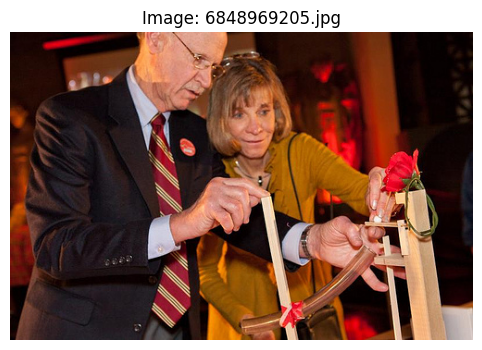


Ground Truth: a couple prepares to drop a small white ball into a tube attached to a wooden stick .
Greedy Search: a man in a black shirt and a man in a black suit are playing a musical instrument .
Beam Search: a man in a red shirt and a man in a black suit are playing a musical instrument .
--------------------------------------------------------------------------------


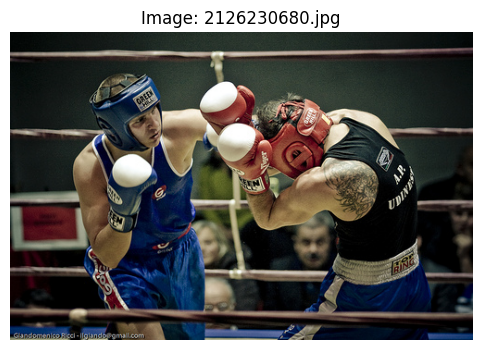


Ground Truth: " two men inside a boxing ring , one with red headgear and one with blue headgear , are engaged in a boxing match ."
Greedy Search: two men in a boxing match .
Beam Search: two men in a boxing match .
--------------------------------------------------------------------------------


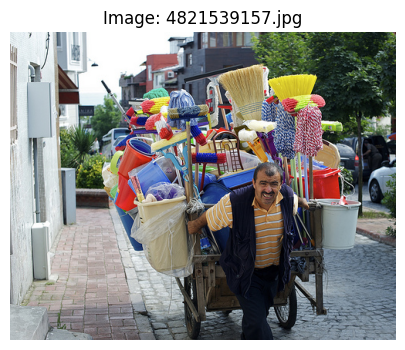


Ground Truth: a man in a striped orange shirt pulls a cart heavily laden with colorful cleaning supplies up a cobblestone street .
Greedy Search: a man in a blue shirt and a woman in a white shirt are walking down the street .
Beam Search: a man is pushing a cart full of cans .
--------------------------------------------------------------------------------


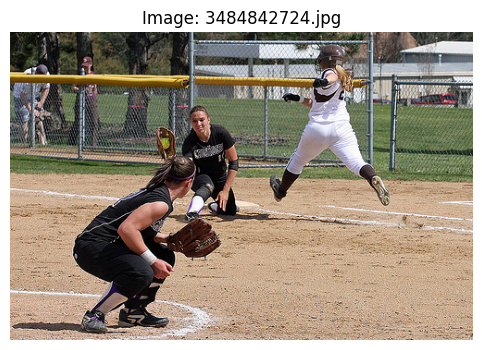


Ground Truth: the first baseman makes hte catch just in time to get the runner out in this softball game .
Greedy Search: a young boy in a baseball uniform is about to hit a baseball .
Beam Search: a young boy in a baseball uniform is playing baseball .
--------------------------------------------------------------------------------


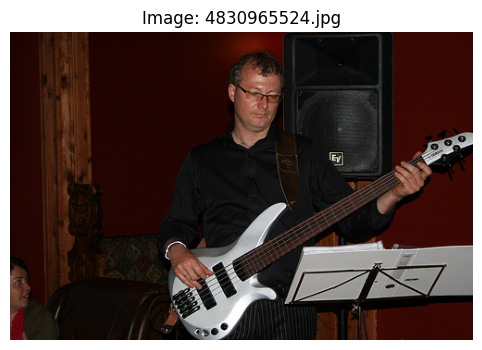


Ground Truth: a man wearing a black shirt is looking at a binder on a music stand while playing a guitar .
Greedy Search: a man in a black shirt and jeans is playing a guitar .
Beam Search: a man in a black shirt playing a guitar .
--------------------------------------------------------------------------------


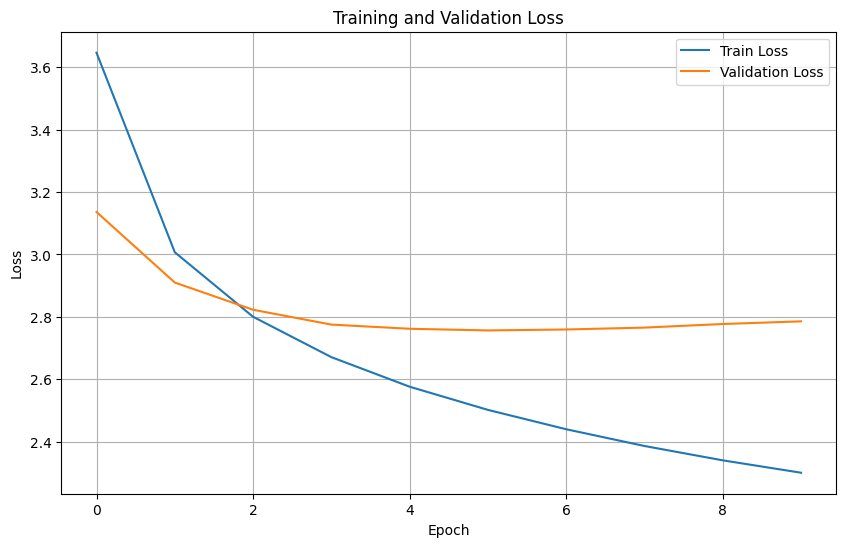


QUANTITATIVE EVALUATION


Generating captions: 100%|██████████| 100/100 [00:00<00:00, 135.46it/s]

BLEU-4 Score: 0.1738
Precision: 0.0182
Recall: 0.0240
F1-Score: 0.0200

Training complete! Model saved as 'caption_model.pth'


In [ ]:
# Import libraries needed for evaluation
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from sklearn.metrics import precision_recall_fscore_support

print("\n" + "="*80)
print("CAPTION EXAMPLES")
print("="*80)

# getting random test images
test_img_names = list(test_captions.keys())
random_imgs = random.sample(test_img_names, min(5, len(test_img_names)))

for img_name in random_imgs:
    # loading image
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path)

    # getting predictions
    feature = features_dict[img_name]
    greedy_caption = greedy_search(model, feature, vocab, device=device)
    beam_caption = beam_search(model, feature, vocab, device=device)

    # displaying results
    plt.figure(figsize=(10, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {img_name}")
    plt.show()

    print(f"\nGround Truth: {test_captions[img_name][0]}")
    print(f"Greedy Search: {greedy_caption}")
    print(f"Beam Search: {beam_caption}")
    print("-" * 80)

# 2. Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()

# 3. Quantitative Evaluation
print("\n" + "="*80)
print("QUANTITATIVE EVALUATION")
print("="*80)

# generating captions for test set
references = []
hypotheses = []

for img_name in tqdm(test_img_names[:100], desc="Generating captions"):
    # getting feature
    feature = features_dict[img_name]

    # generating caption
    predicted_caption = greedy_search(model, feature, vocab, device=device)

    # preparing references
    refs = [cap.split() for cap in test_captions[img_name]]
    references.append(refs)
    hypotheses.append(predicted_caption.split())

# calculating BLEU-4
bleu4_score = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BLEU-4 Score: {bleu4_score:.4f}")

# calculating precision, recall, f1
all_true_tokens = []
all_pred_tokens = []

for refs, hyp in zip(references, hypotheses):
    # using first reference
    all_true_tokens.extend(refs[0])
    all_pred_tokens.extend(hyp)

# getting unique tokens
unique_tokens = list(set(all_true_tokens + all_pred_tokens))
token2idx = {token: idx for idx, token in enumerate(unique_tokens)}

# converting to indices
true_indices = [token2idx[t] for t in all_true_tokens if t in token2idx]
pred_indices = [token2idx[t] for t in all_pred_tokens if t in token2idx]

# padding to same length
max_len = max(len(true_indices), len(pred_indices))
true_indices.extend([0] * (max_len - len(true_indices)))
pred_indices.extend([0] * (max_len - len(pred_indices)))

# calculating metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    true_indices, pred_indices, average='weighted', zero_division=0
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nTraining complete! Model saved as 'caption_model.pth'")